# Clean Room CNN

In [1]:
#import necessary libraries 
import os, shutil
import numpy as np
import pandas as pd 
import matplotlib as plt
import time
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from keras import models
from keras.layers import Dense, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline
import seaborn as sns 

Using TensorFlow backend.


# Preparing our Data

__Create Directory and Allocate Images__

In order to amass our clean room data we used the AED20k Dataset of online images that had prelabeled scenes. The scenes we decided to look at specifically were tagged "kitchen", "living room", and "bedroom". Bathrooms we determined were not necessary as they should be cleaned regardless of thier perceived cleanliness for obvious hygene purposes. In total we were able to download about 2000 images of clean rooms but the real challenge was going to be collecting dirty images. 

In [2]:
#create objects for our images in our train sets
train_clean_room_dir = '/Users/AlexGaujean/Downloads/data/train_folder/train_clean_room'
train_dirty_room_dir = '/Users/AlexGaujean/Downloads/data/train_folder/train_dirty_room'


#create directory objects for our items in our validation and test sets
validation_clean_room_dir = '/Users/AlexGaujean/Downloads/data/validation_folder/val_clean_room'
validation_dirty_room_dir = '/Users/AlexGaujean/Downloads/data/validation_folder/val_dirty_room'
test_clean_room_dir = '/Users/AlexGaujean/Downloads/data/test_folder/test_clean_room'
test_dirty_room_dir = '/Users/AlexGaujean/Downloads/data/test_folder/test_dirty_room'

In [3]:
#create  variables that contain our list of clean and dirty photos
train_imgs_clean = [file for file in os.listdir(train_clean_room_dir) if file.endswith('.jpg')]
val_imgs_clean = [file for file in os.listdir(validation_clean_room_dir) if file.endswith('.jpg')]
test_imgs_clean = [file for file in os.listdir(test_clean_room_dir) if file.endswith('.jpg')]


train_imgs_dirty = [file for file in os.listdir(train_dirty_room_dir) if file.endswith('.jpg')]
val_imgs_dirty = [file for file in os.listdir(validation_dirty_room_dir) if file.endswith('.jpg')]
test_imgs_dirty = [file for file in os.listdir(test_dirty_room_dir) if file.endswith('.jpg')]

In [4]:
#examine the size of each of our train and test set images for our clean data and set up variables to use later
batch_size_train = len(train_imgs_clean) + len(train_imgs_dirty) 
batch_size_val = len(val_imgs_clean) + len(val_imgs_dirty) 
batch_size_test = len(test_imgs_clean) +len(test_imgs_dirty) 

print(batch_size_train, 'train images') 
print(batch_size_val, 'validation images') 
print(batch_size_test, 'test images')

1672 train images
363 validation images
390 test images


In [5]:
#establish directories for all of our train, test, and validation data 
train_dir = '/Users/AlexGaujean/Downloads/data/train_folder'
val_dir = '/Users/AlexGaujean/Downloads/data/validation_folder'
test_dir = '/Users/AlexGaujean/Downloads/data/test_folder'

__Webscraping for Dirty Rooms:__ Run this JavaScript in the chrome console

In [ ]:
#run this Javascript code in the chrome console# 
// pull down jquery into the JavaScript console
var script = document.createElement('script');
script.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.2.0/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(script);



// grab the URLs
var urls = $('.rg_di .rg_meta').map(function() { return JSON.parse($(this).text()).ou; });



// write the URls to file (one per line)
var textToSave = urls.toArray().join('\n');
var hiddenElement = document.createElement('a');
hiddenElement.href = 'data:attachment/text,' + encodeURI(textToSave);
hiddenElement.target = '_blank';
hiddenElement.download = 'urls.txt';
hiddenElement.click();

#run this code in the chrome console# 

In [ ]:
# combine txt files
filenames = ['dirty_bedroom_urls.txt','dirty_kitchen_urls.txt','disorganized_room_urls.txt',
             'messy_bedroom_urls.txt','messy_kitchen_urls.txt','messy_living_room_urls.txt',
            'messy_room_urls.txt','not_clean_bedroom_urls.txt','slightly_messy_rooms_urls.txt']
with open('messy_rooms.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())

In [ ]:
# ensure that different queries does not leave us with identical images by removing duplicate urls

file = open('messy_rooms.txt', 'r')

lines_seen = set() # holds lines already seen
outfile = open('messy_rooms_no_duplicates.txt', "w")
for line in open('messy_rooms.txt', "r"):
    if line not in lines_seen: # not a duplicate
        outfile.write(line)
        lines_seen.add(line)
outfile.close()

In [ ]:
# download images from url txt file
# import the necessary packages
from imutils import paths
import argparse
import requests
import cv2
import os

In [ ]:
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-u", "--urls", required=True,
help="messy_rooms_no_duplicates.txt")
ap.add_argument("-o", "--output", required=True,
help="images")
args = vars(ap.parse_args())

# grab the list of URLs from the input file, then initialize the
# total number of images downloaded thus far
rows = open(args["urls"]).read().strip().split("\n")
total = 0

%tb

__Scale and Normalize Images and Create Datasets__

In [6]:
#import necessary python libraries
import time
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)

In [7]:
#get all the data in the directory split/test and reshape them using ImageDataGenerator from keras
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(64, 64), batch_size= batch_size_train)
#get all the data in the test directory adn reshape them to 64X64 pixel size
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(64, 64), batch_size = batch_size_test)  

# get all the data in the directory split/validation (363 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(64, 64), batch_size = batch_size_val)

Found 1673 images belonging to 2 classes.
Found 390 images belonging to 2 classes.
Found 363 images belonging to 2 classes.


In [8]:
# create our image datasets and corresponding labels for our train, validation and test sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

/Users/AlexGaujean/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag))
/Users/AlexGaujean/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag))
/Users/AlexGaujean/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag))


In [9]:
#reshape our labels so that it is either a 0 for dirty rooms, or 1 for clean rooms 
train_y = np.reshape(train_labels[:,0], (batch_size_train,1))
test_y = np.reshape(test_labels[:,0], (batch_size_test,1))
val_y = np.reshape(val_labels[:,0], (batch_size_val,1))

[0.]


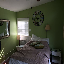

In [10]:
#check to make sure the labels correspond to the correct images 
print(train_y[1412])
array_to_img(train_images[1412])

__Reshape Image Arrays for CNN Use__

In [11]:
# Explore our datasets again and print the shape of each of our images to ensure that we converted it properly
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 1672
Number of testing samples: 390
Number of validation samples: 363
train_images shape: (1672, 64, 64, 3)
train_labels shape: (1672, 2)
test_images shape: (390, 64, 64, 3)
test_labels shape: (390, 2)
val_images shape: (363, 64, 64, 3)
val_labels shape: (363, 2)


In [12]:
#reshape our train, test, val image data into a single row that can then be used
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape, '= train size')
print(test_img.shape, '= test size')  
print(val_img.shape, '= val size')

(1672, 12288) = train size
(390, 12288) = test size
(363, 12288) = val size


# CNN Models

In [13]:
#import necessary libraries
from keras import models
from keras import layers

__Densely Connected Network: Baseline Model__

We are going to try out a number of different models starting with a densely connected network to run as our baseline. In addition, we are going to try CNN's that we have constructed ourselves as well as a number of Transfer Learning methods, specifically VGG16 and ResNet50.

In [14]:
#instantiate our model and add our hidden layers
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(15, activation='relu', input_shape=(12288,)))#3 hidden layers
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
#compile our model and fit it to our training data
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history1 = model.fit(train_img,
                    train_y,
                    epochs=100,
                    batch_size=1672,
                    validation_data=(val_img, val_y))

Instructions for updating:
Use tf.cast instead.
Train on 1672 samples, validate on 363 samples
Epoch 1/100
1672/1672 [==============================] - 3s 2ms/step - loss: 0.6869 - acc: 0.5664 - val_loss: 0.6567 - val_acc: 0.7025
Epoch 2/100
1672/1672 [==============================] - 0s 156us/step - loss: 0.6806 - acc: 0.5700 - val_loss: 0.6431 - val_acc: 0.7107
Epoch 3/100
1672/1672 [==============================] - 0s 131us/step - loss: 0.6761 - acc: 0.5688 - val_loss: 0.6392 - val_acc: 0.7052
Epoch 4/100
1672/1672 [==============================] - 0s 78us/step - loss: 0.6737 - acc: 0.5736 - val_loss: 0.6360 - val_acc: 0.7080
Epoch 5/100
1672/1672 [==============================] - 0s 114us/step - loss: 0.6717 - acc: 0.5736 - val_loss: 0.6331 - val_acc: 0.7080
Epoch 6/100
1672/1672 [==============================] - 0s 79us/step - loss: 0.6699 - acc: 0.5778 - val_loss: 0.6331 - val_acc: 0.7107
Epoch 7/100
1672/1672 [==============================] - 0s 76us/step - loss: 0.6682 - 

Epoch 59/100
1672/1672 [==============================] - 0s 79us/step - loss: 0.6486 - acc: 0.6274 - val_loss: 0.5780 - val_acc: 0.7218
Epoch 60/100
1672/1672 [==============================] - 0s 80us/step - loss: 0.6472 - acc: 0.5945 - val_loss: 0.6571 - val_acc: 0.6088
Epoch 61/100
1672/1672 [==============================] - 0s 79us/step - loss: 0.6467 - acc: 0.6274 - val_loss: 0.5775 - val_acc: 0.7190
Epoch 62/100
1672/1672 [==============================] - 0s 77us/step - loss: 0.6450 - acc: 0.5993 - val_loss: 0.6565 - val_acc: 0.6088
Epoch 63/100
1672/1672 [==============================] - 0s 76us/step - loss: 0.6456 - acc: 0.6322 - val_loss: 0.5763 - val_acc: 0.7190
Epoch 64/100
1672/1672 [==============================] - 0s 78us/step - loss: 0.6448 - acc: 0.5987 - val_loss: 0.6559 - val_acc: 0.6143
Epoch 65/100
1672/1672 [==============================] - 0s 85us/step - loss: 0.6446 - acc: 0.6334 - val_loss: 0.5756 - val_acc: 0.7190
Epoch 66/100
1672/1672 [=================

In [16]:
#examine our evaluation metrics for how our model on the training set
results_train = model.evaluate(train_img, train_y)

1672/1672 [==============================] - 0s 93us/step


In [17]:
#examine our evaluation metrics for how our model performed on the test set 
results_test = model.evaluate(test_img, test_y)

390/390 [==============================] - 0s 286us/step


In [18]:
# print the [loss, and accuracy] of our training data
results_train

[0.6271645007521341, 0.6501196172248804]

In [19]:
#print the [loss and accuracy] of our test data
results_test

[0.6459931181027339, 0.5974358971302326]

__ConvNet: Initial Model__

In [20]:
#import earlystopping from keras and set a variable called earlystopping that ends our run model if our validation loss doesnt increase by a certain amount in a number of epochs
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 7) 

In [21]:
# get all the data in the directory split/test (271 images), and reshape them
# get all the data in the directory split/train (2477 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(64, 64), batch_size= batch_size_train)


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(64, 64), batch_size = batch_size_test)   

# get all the data in the directory split/validation (257 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(64, 64), batch_size = batch_size_val) 

Found 1673 images belonging to 2 classes.
Found 390 images belonging to 2 classes.
Found 363 images belonging to 2 classes.


In [22]:
#instantiate our cnn_model with conv layers and maxpooling and a flatten layer as our last hidden layer 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape = (64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [23]:
#fit our cnn to the training set 
history = model.fit(train_images,
                    train_y,
                    epochs=75,
                    batch_size=32,
                    validation_data=(val_images, val_y), callbacks = [early_stopping]) 

Train on 1672 samples, validate on 363 samples
Epoch 1/75
1672/1672 [==============================] - 10s 6ms/step - loss: 0.6873 - acc: 0.5580 - val_loss: 0.6418 - val_acc: 0.7080
Epoch 2/75
1672/1672 [==============================] - 8s 5ms/step - loss: 0.6781 - acc: 0.5843 - val_loss: 0.6324 - val_acc: 0.7107
Epoch 3/75
1672/1672 [==============================] - 8s 5ms/step - loss: 0.6695 - acc: 0.5993 - val_loss: 0.7973 - val_acc: 0.2920
Epoch 4/75
1672/1672 [==============================] - 8s 5ms/step - loss: 0.6616 - acc: 0.6142 - val_loss: 0.8615 - val_acc: 0.2920
Epoch 5/75
1672/1672 [==============================] - 8s 5ms/step - loss: 0.6570 - acc: 0.6489 - val_loss: 0.6489 - val_acc: 0.6887
Epoch 6/75
1672/1672 [==============================] - 8s 5ms/step - loss: 0.6464 - acc: 0.6501 - val_loss: 0.5713 - val_acc: 0.7107
Epoch 7/75
1672/1672 [==============================] - 8s 5ms/step - loss: 0.6246 - acc: 0.6651 - val_loss: 0.7576 - val_acc: 0.3802
Epoch 8/75
167

In [24]:
#save my model to drive only need to do this once
model_json = model.to_json()
with open("model_cnn_one.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_one.h5")
print("Saved model to drive")

Saved model to drive


__Evaluating Initial CNN Model__


Not sure if our model is actually able to determine clean or dirty rooms or if there is just a common feature or patern outside of the desired image content for our training set data that results in our model overfitting. So want to check how it is performing on each one of our datasets where our validation and test sets for our dirty images have been sorted, filtered and made to look exactly like our clean image photos. 

In [25]:
#examine our evaluation metrics for how our model performed on the test set 
results_one_test = model.evaluate(test_images, test_y)

#and our training data
results_one_train = model.evaluate(train_images, train_y)

#do the same for our validation images and targets
results_one_validate = model.evaluate(val_images, val_y)

363/363 [==============================] - 1s 2ms/step


In [26]:
# print the [loss, and accuracy] of our training data
model_one_acc_train = results_one_train

In [28]:
# check the results for our validation set 
model_one_acc_val = results_one_validate

In [29]:
#print the [loss and accuracy] of our test data
model_one_acc_test = results_one_test

__Save our Model Weights and Probabilities__

In addition to using our model to predict a clean and dirty room we also thought it would be useful to have our final output layer use a softmax function instead of a sigmoid function so each image could return us a predicted probability, which we can then use as a "cleanliness" metric. Using keras' predict_proba method we can examine if this might be worth our time. 

In [30]:
#going to try and use this model to output a predictive value 
model_proba_train = model.predict_proba(train_images)

#examining the probability as a metric for how dirty or clean a room will be 
model_proba_test = model.predict_proba(test_images)

In [44]:
#examine our probabilities that are being fed into the output layer and then converted to a 0 or 1 using the sigmoid function
model_proba_test[10:20]

array([[0.05072623],
       [0.14476797],
       [0.5585816 ],
       [0.41537106],
       [0.16759878],
       [0.08846781],
       [0.5759965 ],
       [0.17328486],
       [0.6138184 ],
       [0.76122534]], dtype=float32)

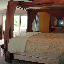

In [46]:
array_to_img(test_images[19])

__VGG16 Model: Transfer Learning__

Imported VGG16 as our base model with weights set to "imagenet" and used transfer learning techniques to construct a network with 16 pretrained layers. We then added and number of our own dense and dropout layers that performed well for our initial CNN model. Our output layer we left as a sigmoid activation using binary crossentropy to calculate our loss. 

In [41]:
#import necessary model for transfer learning
from keras.applications import VGG16
from keras.layers import Dense, Dropout
#instantiate our base_model with VGG16 after removing an output layer and altering the input shape
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (64,64,3))

In [42]:
# instantiate our new model and add a layer to the pretrained base_model
model = models.Sequential()
model.add(base_model) 
model.add(Dense(512, activation ='relu')) #, data_format = 'channels_last')
model.add(Dropout(0.4)) 
model.add(Dense(64, activation ='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [43]:
#compile our model using binary_crossentropy as the loss parameter
model.compile(loss ='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [47]:
#make sure that we do not retrain the first 16 pretrained layers of our model and only train the following layers
for layer in model.layers[:16]:
    layer.trainable = False
for layer in model.layers[16:]:
    layer.trainable = True

In [ ]:
#fit our train images and train labels to our ResNet transfer learning model
history_3 = model.fit(train_images,
                    train_y,
                    epochs=75,
                    batch_size=32,
                    validation_data=(val_images, val_y), callbacks = [early_stopping])

/Users/AlexGaujean/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 1679 samples, validate on 366 samples
Epoch 1/75
 320/1679 [====>.........................] - ETA: 3:07 - loss: 0.6858 - acc: 0.6031

In [ ]:
#save our weights and model to our folder
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights_vgg.h5")
print("Saved model to drive")

In [ ]:
#examine our evaluation metrics for how our model performed on the test set 
results_vgg_test = model.evaluate(test_images, test_y)

#and our training data
results_vgg_train = model.evaluate(train_images, train_y)

#do the same for our validation images and targets
results_vgg_validate = model.evaluate(val_images, val_y)

## print the [loss, and accuracy] of our training data
model_vgg_acc_train = results_train

# check the results for our validation set 
model_vgg_acc_val = results_validate

#print the [loss and accuracy] of our test data
model_vgg_acc_test = results_test

In [ ]:
#locally save our weights and model to our folder
model_vgg_json = model.to_json()
model_vgg_weights = model.get_weights()
model_vgg_inputs = model.inputs
model_vgg_outputs = model.outputs

In [ ]:
#evaluate our model using keras.summary() method
model.summary()

__Resnet Model: Transfer Learning 2__

In [49]:
#import necessary libraries for ResNet
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import 

In [55]:
#import necessary libraries for ResNet
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, MaxPooling2D



#instantiate a base_model with our ResNet layer
base_model = ResNet50(weights='imagenet', include_top = False)



#setup our model with the ResNet as the base and add a few more hidden layers
model = models.Sequential()

model.add(base_model) 

model.add(GlobalAveragePooling2D())

model.add(Dense(1024,  activation='relu')) 
model.add(Dropout(0.5)) 

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))


model.add(layers.Dense(1, activation='sigmoid'))


#compile our model using binary_crossentropy as the loss parameter
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])



#make sure that we do not retrain the first 50 pretrained layers of our model
for layer in model.layers[:50]:
    layer.trainable = False
for layer in model.layers[50:]:
    layer.trainable = True

    
#fit our training images and training labels to our model
history_3 = model.fit(train_images,
                    train_y,
                    epochs=75,
                    batch_size=32,
                    validation_data=(val_images, val_y), callbacks = [early_stopping])

In [ ]:
#examine our evaluation metrics for how our model performed on the test set 
results_res_test = model.evaluate(test_images, test_y)

#and our training data
results_res_train = model.evaluate(train_images, train_y)

#do the same for our validation images and targets
results_res_validate = model.evaluate(val_images, val_y)

## print the [loss, and accuracy] of our training data
model_res_acc_train = results_train

# check the results for our validation set 
model_res_acc_val = results_validate

#print the [loss and accuracy] of our test data
model_res_acc_test = results_test

In [ ]:
#locally save our weights and model
model_res_json = model.to_json()
model_res_weights = model.get_weights()
model_res_inputs = model.inputs
model_res_outputs = model.outputs

# Visualizing our Layers

The goal here is to visualize our images within the intermediate layers for our model

In [87]:
#import necessary libraries 
from keras import models
from keras.layers import Dense, Dropout

In [ ]:
# use our locally saved variable of our model outputs [list of tensors] to select an image tensor
img_tensor = model_res_outputs[150]

# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

In [122]:
#use our locally saved variable of our model outputs [list of tensors] to select an image tensor
img_tensor = model_vgg_outputs[150]
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

NameError: name 'model_vgg_outputs' is not defined

In [132]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:10]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

NameError: name 'img_tensor' is not defined

NameError: name 'activations' is not defined

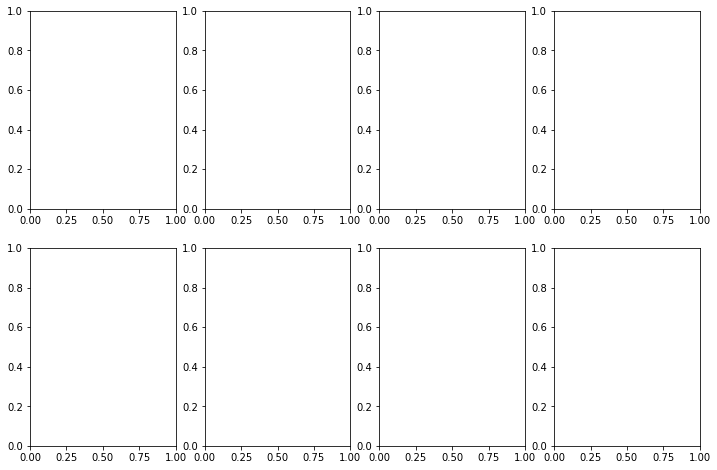

In [121]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

In [147]:
#create a dictionary that will be used to construct our barchart that will contain accuracy metrics for our train and test set for each model that we ran
auc_dict = {'Model': ['Baseline','Baseline', 'Simple_ConvNet', 'Simple_ConvNet', 'VGG16', 'VGG16','ResNet', 'ResNet'], 
            'Accuracy': [.6337, .7513, .7784, .7795, .9988, .9051, .5455, .6948], 
            'type':['Train','Test','Train','Test','Train','Test','Train','Test']}

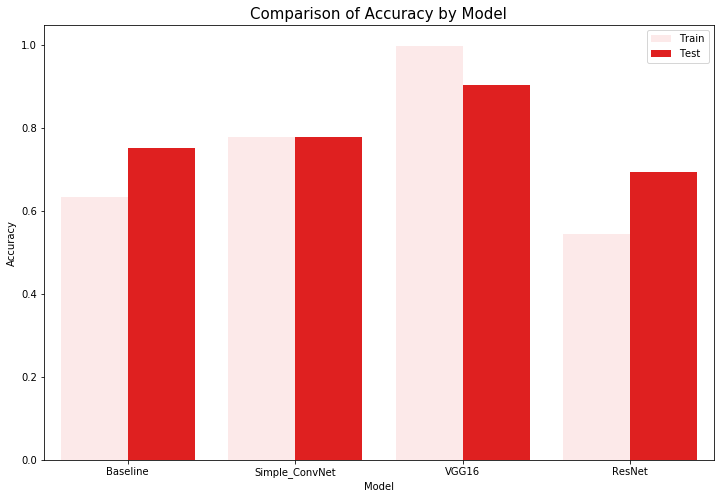

In [148]:
# Bar plot that shows the different accuracy scores for each of our models, train and test set. 
plt.figure(figsize=(12,8))
accuracy = pd.DataFrame(auc_dict, columns = auc_dict.keys())
ax = sns.barplot(x="Model", y="Accuracy", hue="type", data=accuracy, color='red')
plt.title('Comparison of Accuracy by Model',fontsize = 15)
plt.legend(loc="upper right")